# DEG error analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import upath
import extras

loading extras module


In [3]:
import logging

format_str = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(filename="plot_roc_curves.log", format=format_str)
# logging.getLogger("gcsfs").setLevel(logging.INFO)
# logging.getLogger("fsspec").setLevel(logging.INFO)
logging.getLogger("extras").setLevel("DEBUG")
logging.captureWarnings(True)

In [4]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230317_06h00m45s")
# print(extras.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"

In [5]:
df_gene_stats = extras.load_gene_stats(path_root)

### checking pvals

False    16036
True        27
Name: significant_bh_fdr=0.10, dtype: int64


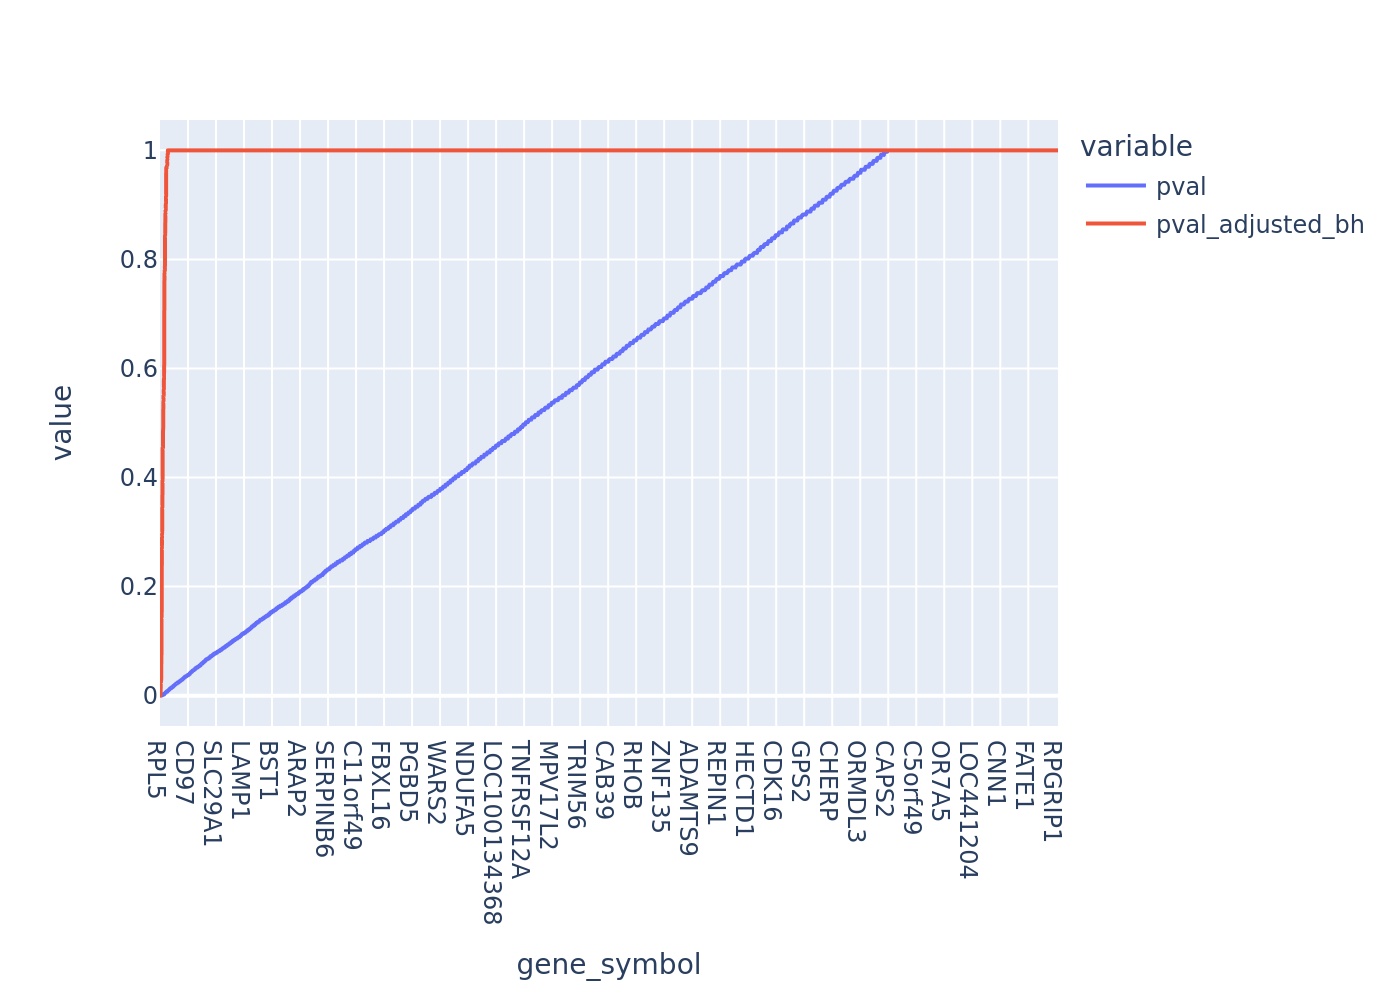

In [6]:
subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00", "04"]
# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]
fig = px.line(
    subset_gene_stats.sort_values("pval").reset_index(),
    x="gene_symbol",
    y=columns,
)
fig.show(renderer="png", scale=2)

### volcanos for all experiment setups

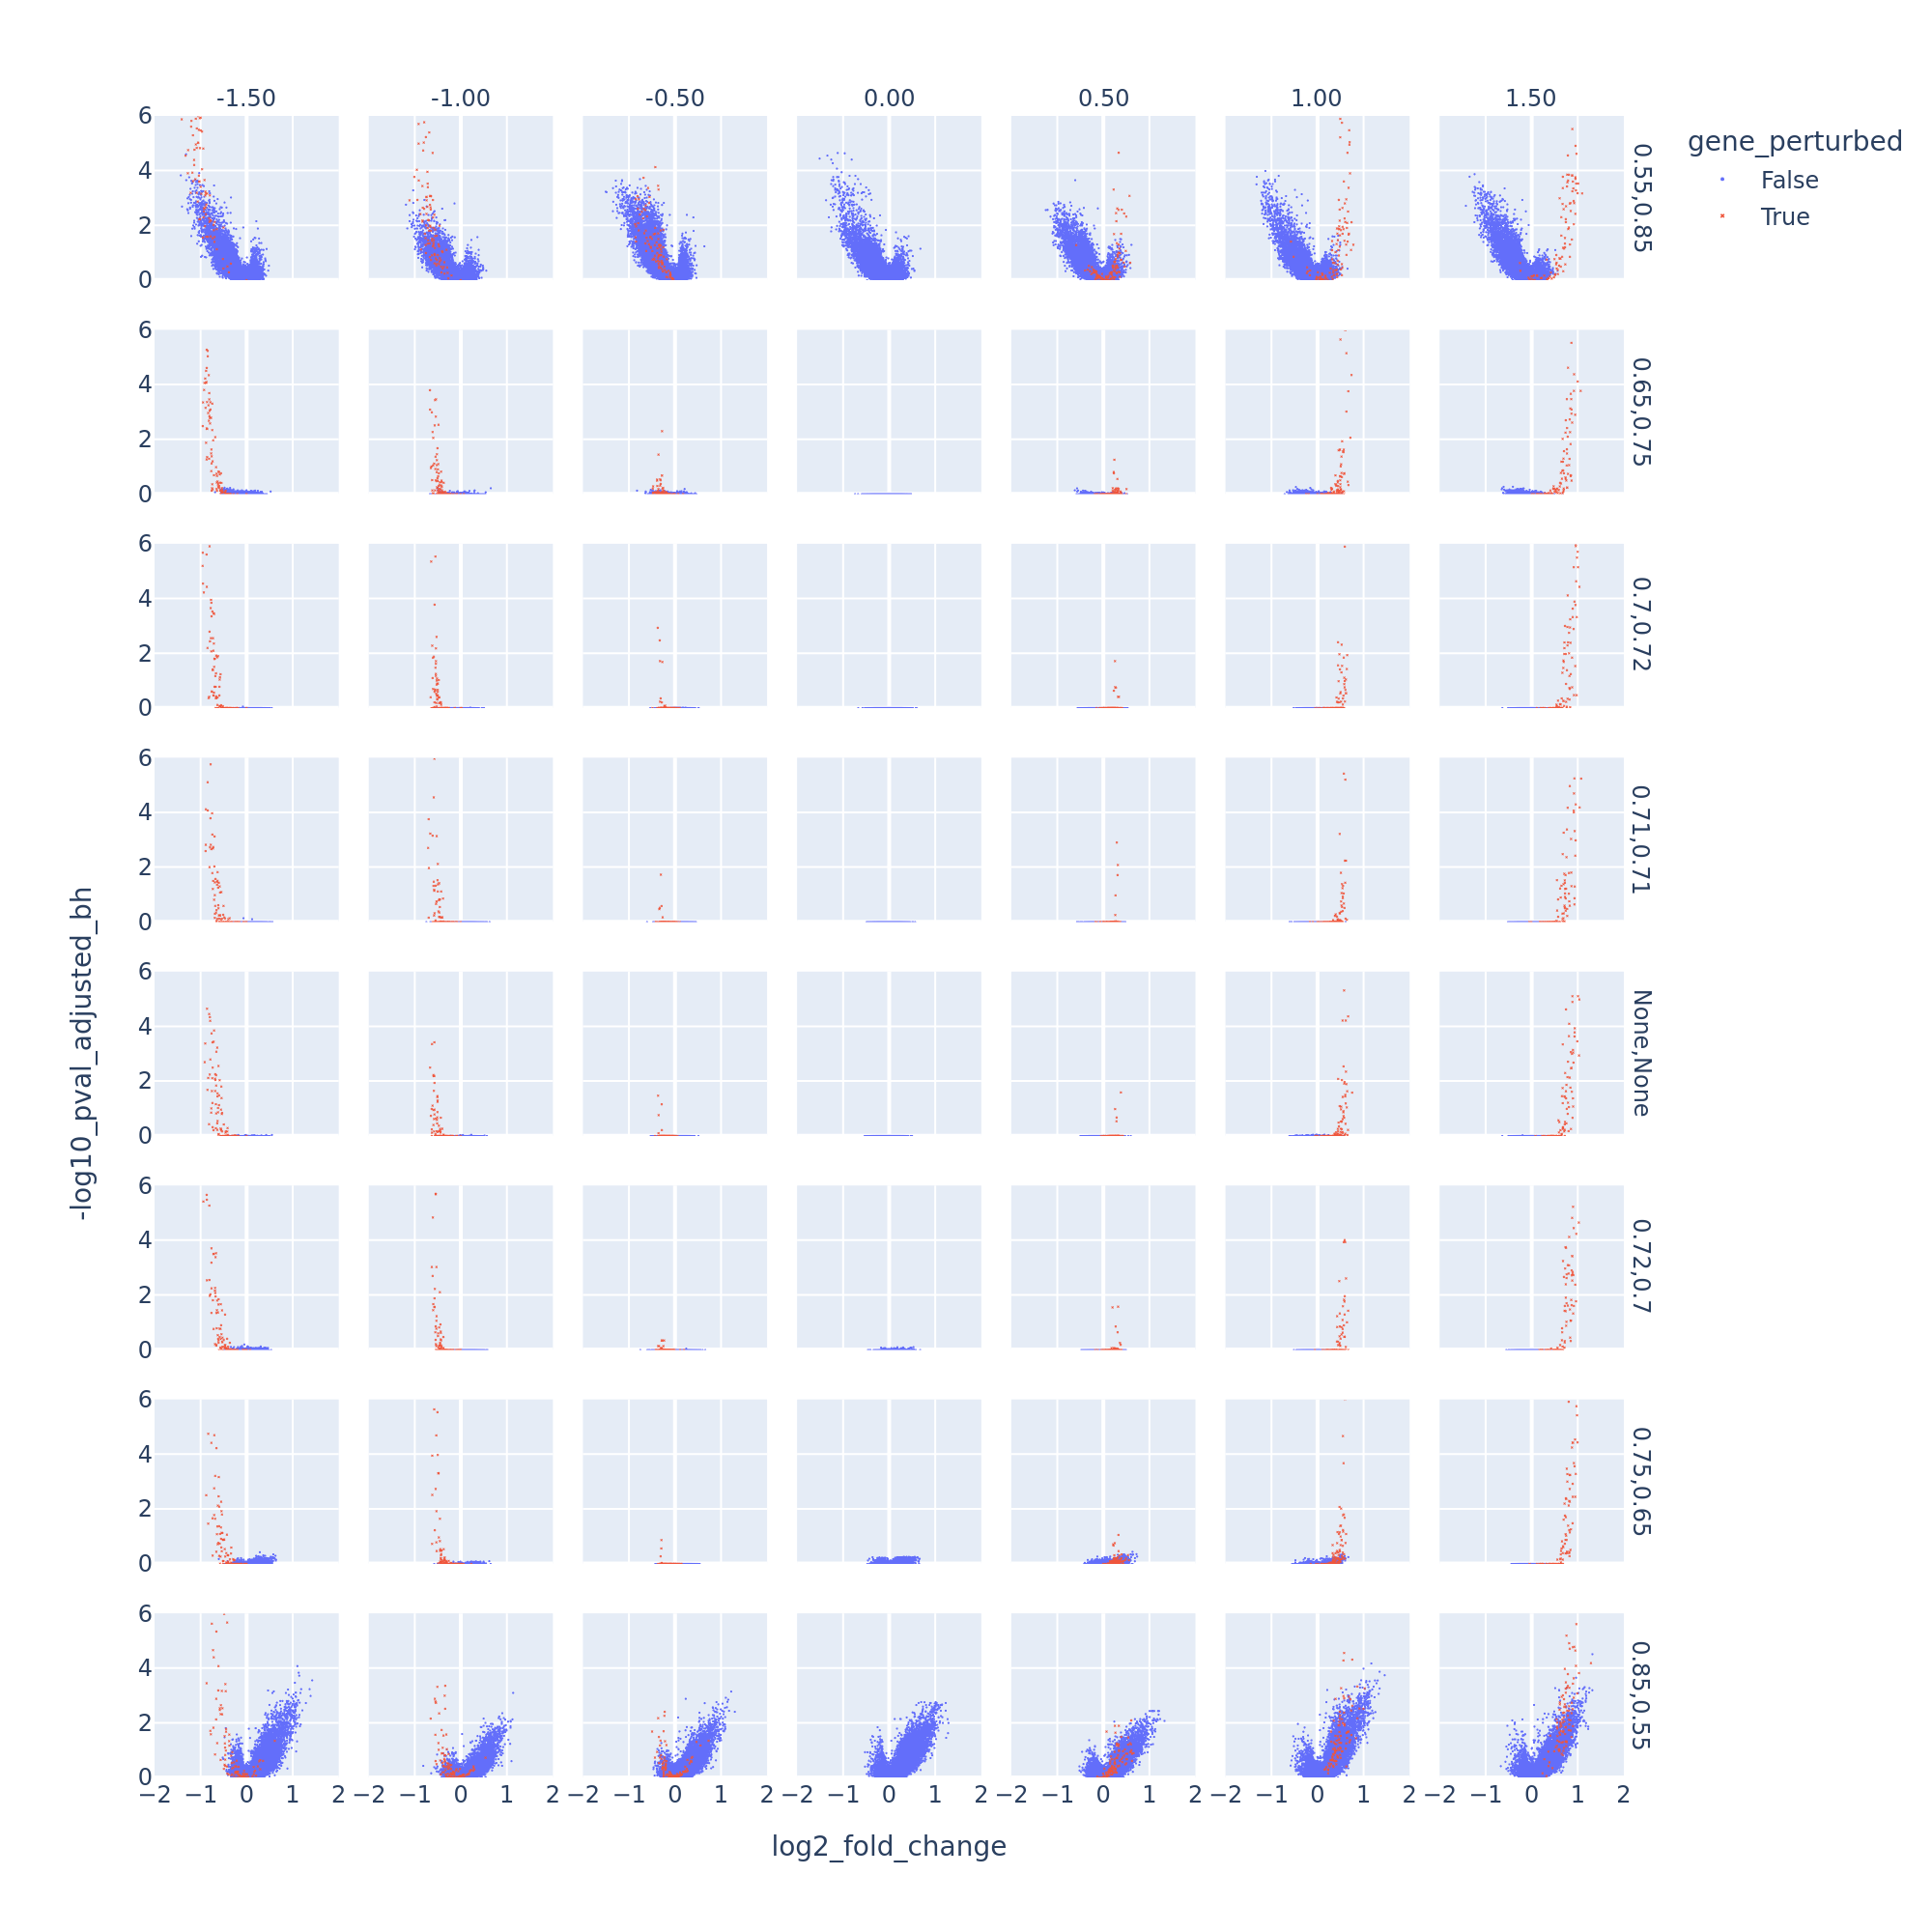

In [7]:
df_to_plot = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False)
fig = extras.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

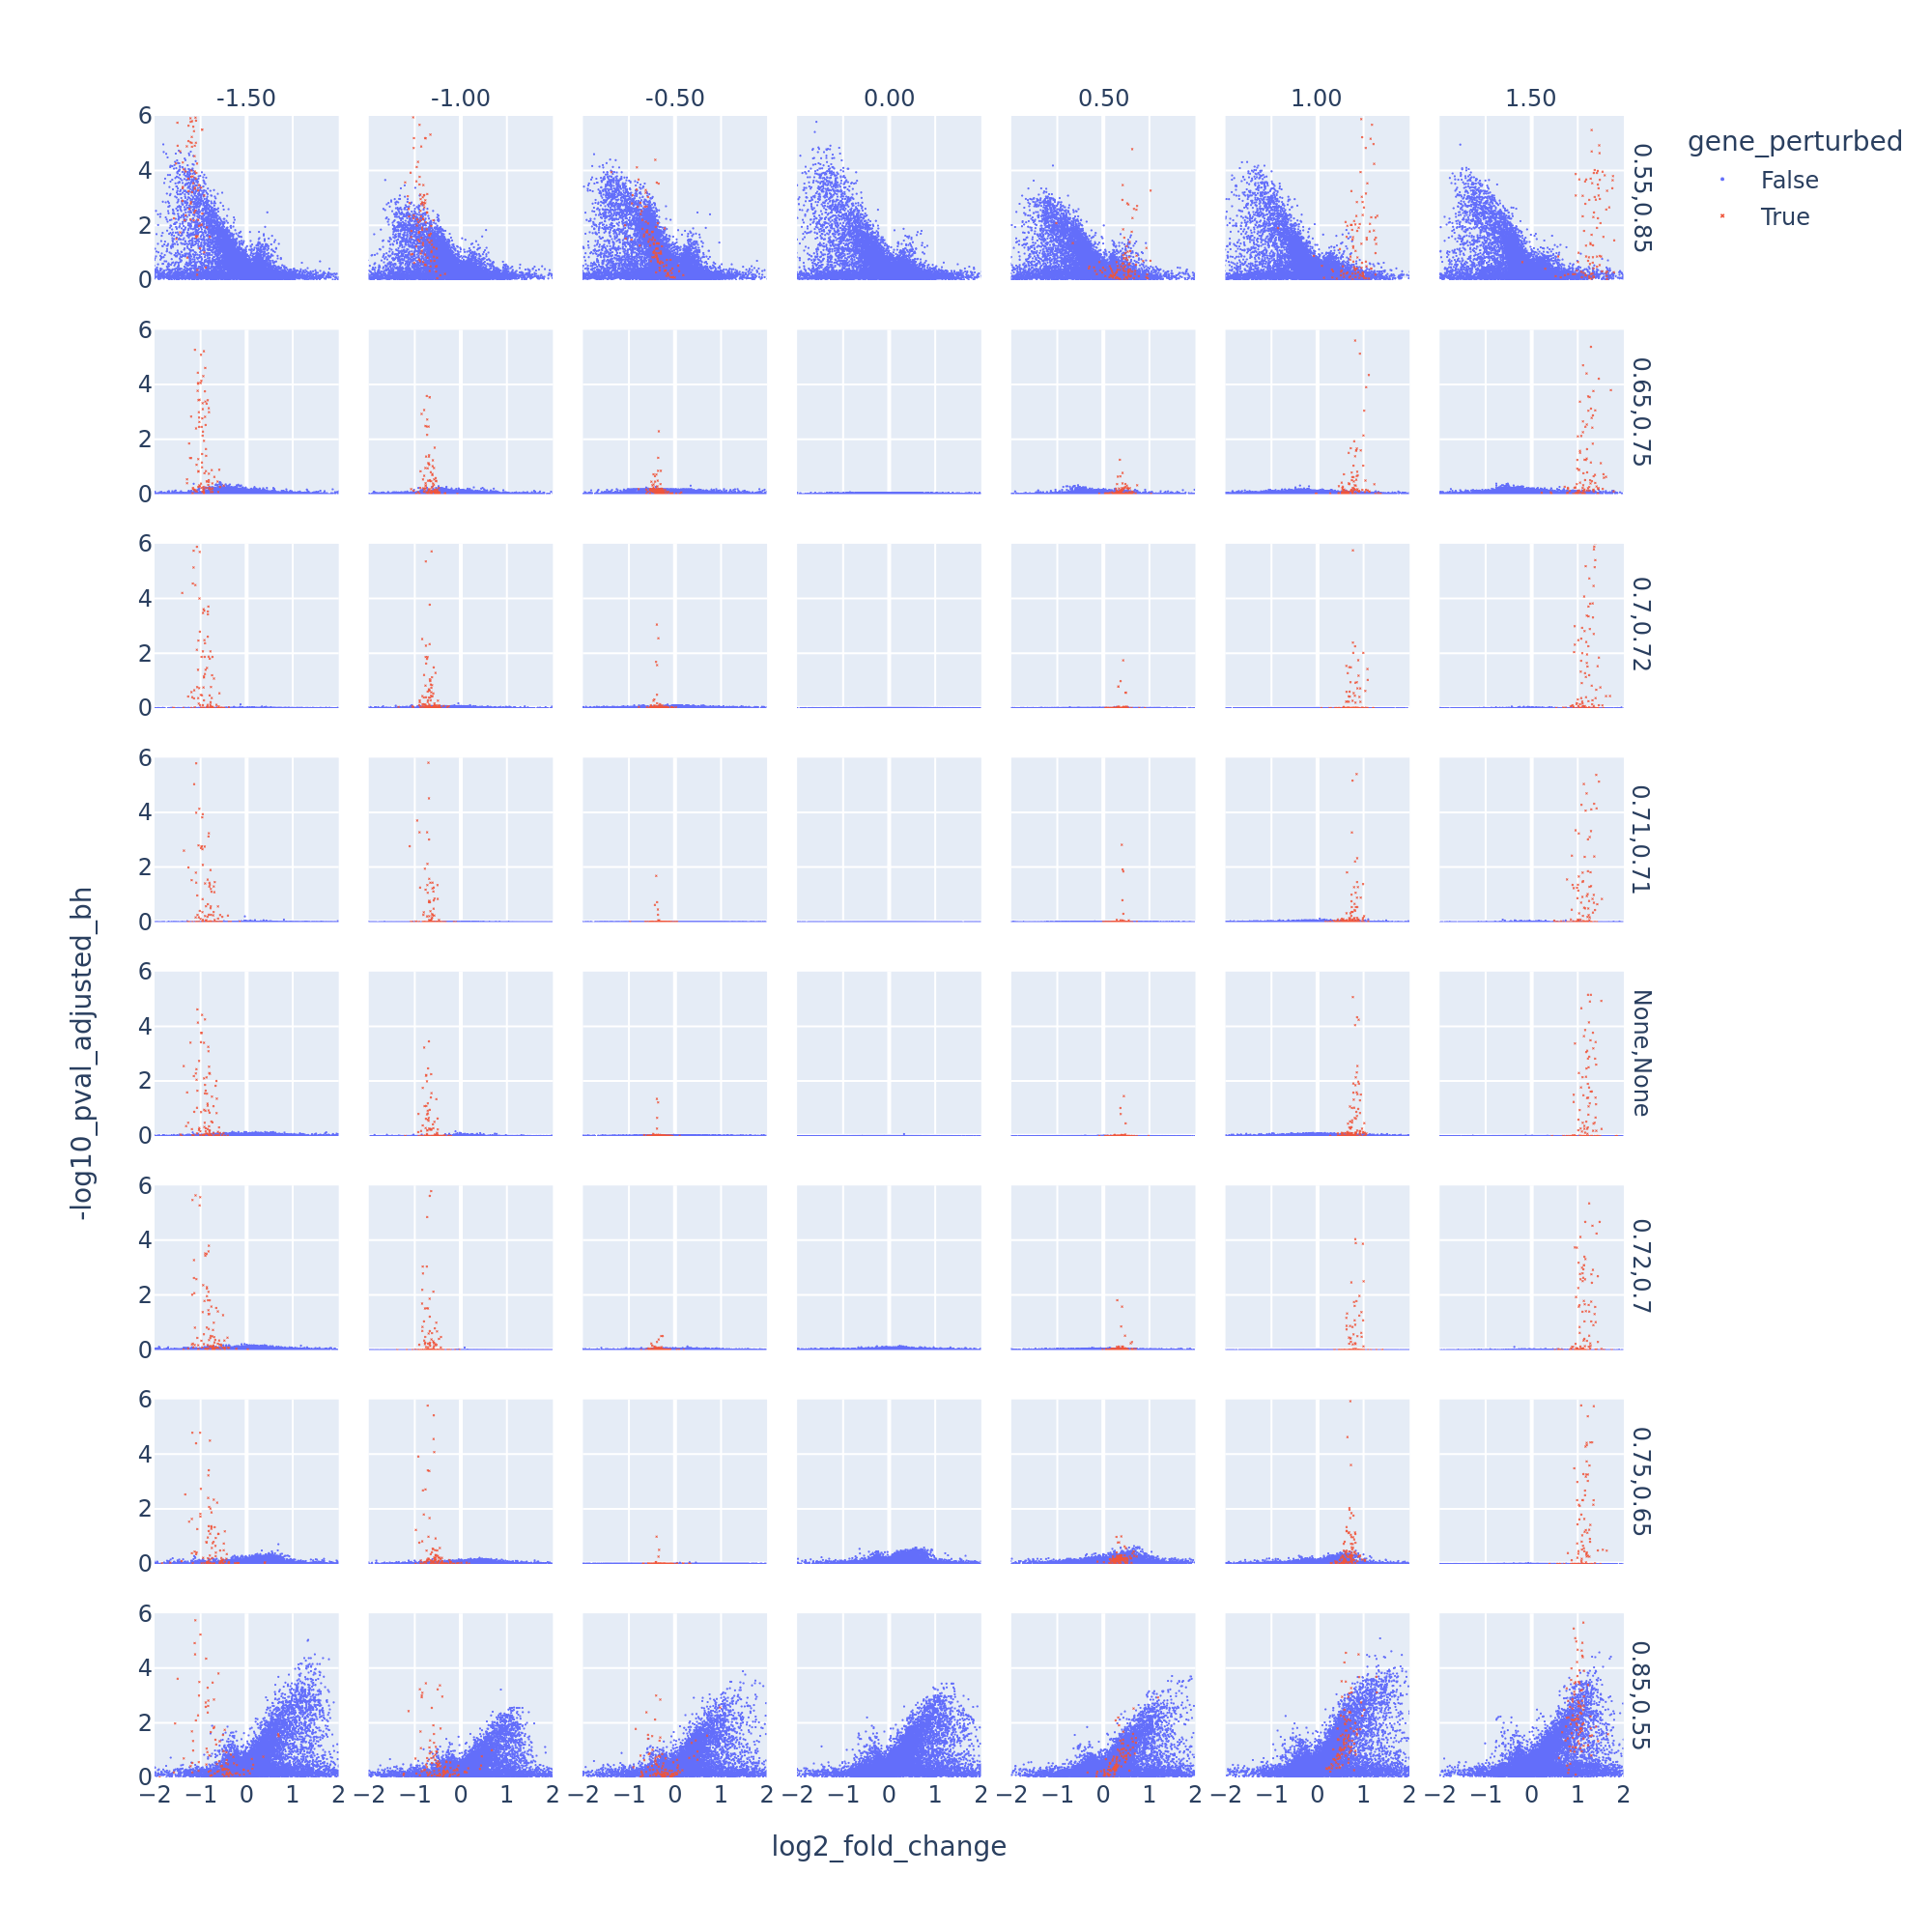

In [8]:
df_to_plot = df_gene_stats.xs("bulk", level="origin", drop_level=False)
fig = extras.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

## ROC, PPV, etc by p-value thresholds

In [9]:
score_column = "-log10_pval_signed_directional"
# score_column = "-log10_pval_adjusted_bh_signed_directional"

In [25]:
df = (
    df_gene_stats
    .loc[df_gene_stats.index.get_level_values("log2_fc") != "0.00"]
    .xs("malignant_cibersortx", level="origin", drop_level=False)
    # 
)
df_roc_curves, df_roc_auc_scores = extras.calculate_roc(df, score_column)
df_precision_recall_curves, df_precision = extras.calculate_precision_and_recall(df, score_column)

### ROC (TPR & FPR)

In [26]:
extras.make_table_scores(df_roc_auc_scores)

log2_fc,-1.50,-1.00,-0.50,0.50,1.00,1.50
malignant_means,,,,,,
"0.55,0.85",0.957797,0.913449,0.789039,0.749284,0.861098,0.920811
"0.65,0.75",0.956600,0.920394,0.834311,0.803281,0.907790,0.950346
"0.7,0.72",0.943099,0.928752,0.806155,0.809765,0.928971,0.959888
"0.71,0.71",0.933655,0.926403,0.781828,0.821826,0.916409,0.947150
"None,None",0.952238,0.922968,0.817413,0.831340,0.913975,0.964752
"0.72,0.7",0.935802,0.917889,0.802450,0.810580,0.928868,0.955788
"0.75,0.65",0.915828,0.875116,0.786018,0.806605,0.910037,0.948705
"0.85,0.55",0.823985,0.786067,0.670988,0.732387,0.828854,0.918812


In [27]:
df_roc_curves

fpr   tpr  \
origin               malignant_means log2_fc run_id                        
malignant_cibersortx 0.55,0.85       -1.50   00     0     0.000000  0.00   
                                                    1     0.000000  0.01   
                                                    2     0.000000  0.21   
                                                    3     0.000063  0.21   
                                                    4     0.000063  0.25   
...                                                            ...   ...   
                     0.85,0.55       1.50    04     2404  0.998622  1.00   
                                                    2405  0.998872  1.00   
                                                    2406  0.999186  1.00   
                                                    2407  0.999436  1.00   
                                                    2408  1.000000  1.00   

                                                          -log10_pval_signed_directional  
origin               malignant_means log2_fc run_id                                       
malignant_cibersortx 0.55,0.85       -1.50   00     0                          17.046150  
                                                    1                          16.046150  
                                                    2                           9.043907  
                                                    3                           9.024111  
                                                    4                           8.800155  
...                                                                                  ...  
                     0.85,0.55       1.50    04     2404                       -3.229788  
                                                    2405                       -3.285293  
                                                    2406                       -3.397763  
                                                    2407                       -3.420491  
                                                    2408                       -6.416983  

[477936 rows x 3 columns]

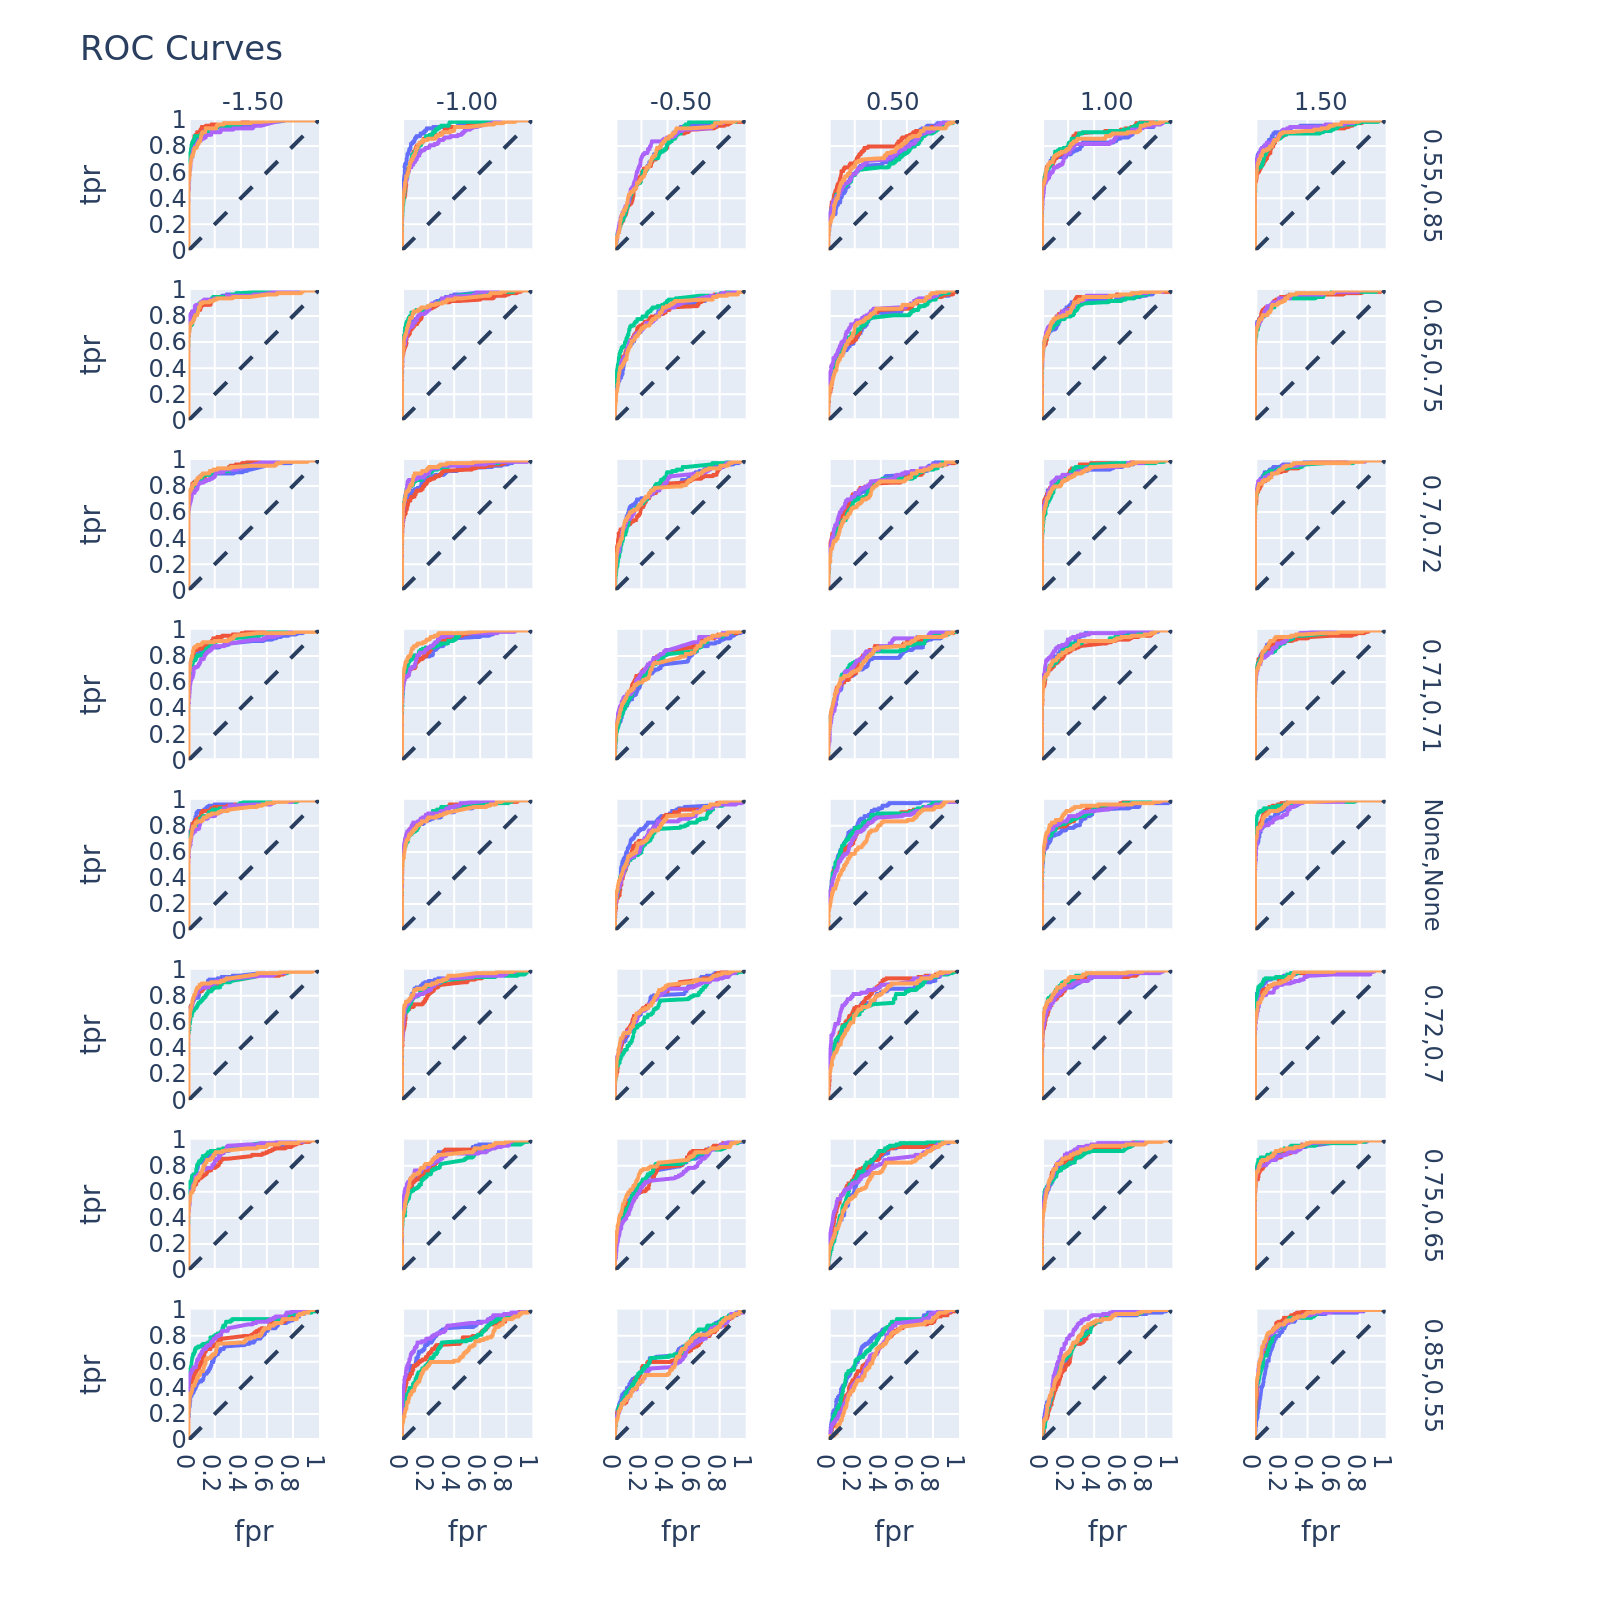

In [28]:
fig = extras.plot_roc(df_roc_curves)
fig.show(renderer="png", scale=2)

### PPV (precision)

In [30]:
extras.make_table_scores(df_precision)

log2_fc,-1.50,-1.00,-0.50,0.50,1.00,1.50
malignant_means,,,,,,
"0.55,0.85",0.039933,0.063608,0.017567,0.013579,0.027454,0.030049
"0.65,0.75",0.891484,0.887340,0.614634,0.850000,0.782897,0.834127
"0.7,0.72",0.954502,0.951465,0.661538,0.800000,0.992593,0.949837
"0.71,0.71",0.928252,0.861604,0.533333,0.950000,0.961086,0.929024
"None,None",0.921953,0.964037,1.000000,0.600000,0.976548,0.958351
"0.72,0.7",0.887694,0.966447,0.350000,0.800000,0.988889,0.948069
"0.75,0.65",0.768939,0.921212,0.485714,0.642424,0.857926,0.940990
"0.85,0.55",0.050707,0.135733,0.012263,0.020471,0.021416,0.032188


In [31]:
extras.make_table_scores_with_stddev(df_precision)

log2_fc,-1.50,-1.00,-0.50,0.50,1.00,1.50
malignant_means,,,,,,
"0.55,0.85",0.04±0.01,0.06±0.05,0.02±0.00,0.01±0.01,0.03±0.01,0.03±0.01
"0.65,0.75",0.89±0.12,0.89±0.12,0.61±0.53,0.85±0.22,0.78±0.20,0.83±0.21
"0.7,0.72",0.95±0.02,0.95±0.07,0.66±0.48,0.80±0.45,0.99±0.02,0.95±0.03
"0.71,0.71",0.93±0.14,0.86±0.26,0.53±0.51,0.95±0.11,0.96±0.06,0.93±0.06
"None,None",0.92±0.11,0.96±0.04,1.00±0.00,0.60±0.55,0.98±0.02,0.96±0.07
"0.72,0.7",0.89±0.10,0.97±0.05,0.35±0.49,0.80±0.45,0.99±0.02,0.95±0.04
"0.75,0.65",0.77±0.30,0.92±0.11,0.49±0.50,0.64±0.41,0.86±0.16,0.94±0.05
"0.85,0.55",0.05±0.07,0.14±0.26,0.01±0.01,0.02±0.01,0.02±0.00,0.03±0.01


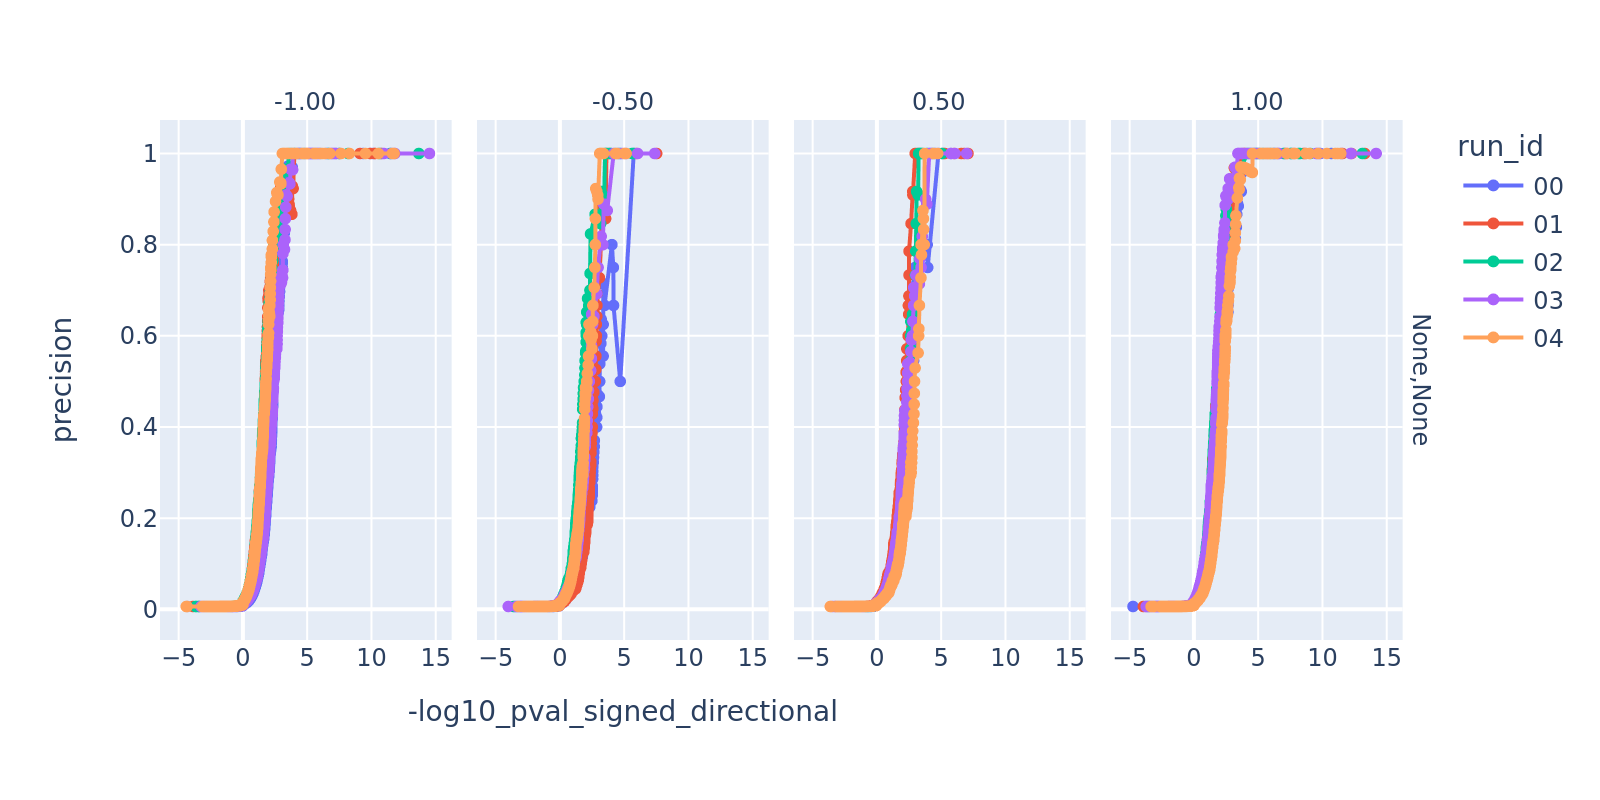

In [32]:
df_to_plot = (
    df_precision_recall_curves
    .xs("None,None", level="malignant_means", drop_level=False)
    # .xs("1.50", level="log2_fc", drop_level=False)
    .loc[:, :, "-1.00":"1.00", :]
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)
# fig

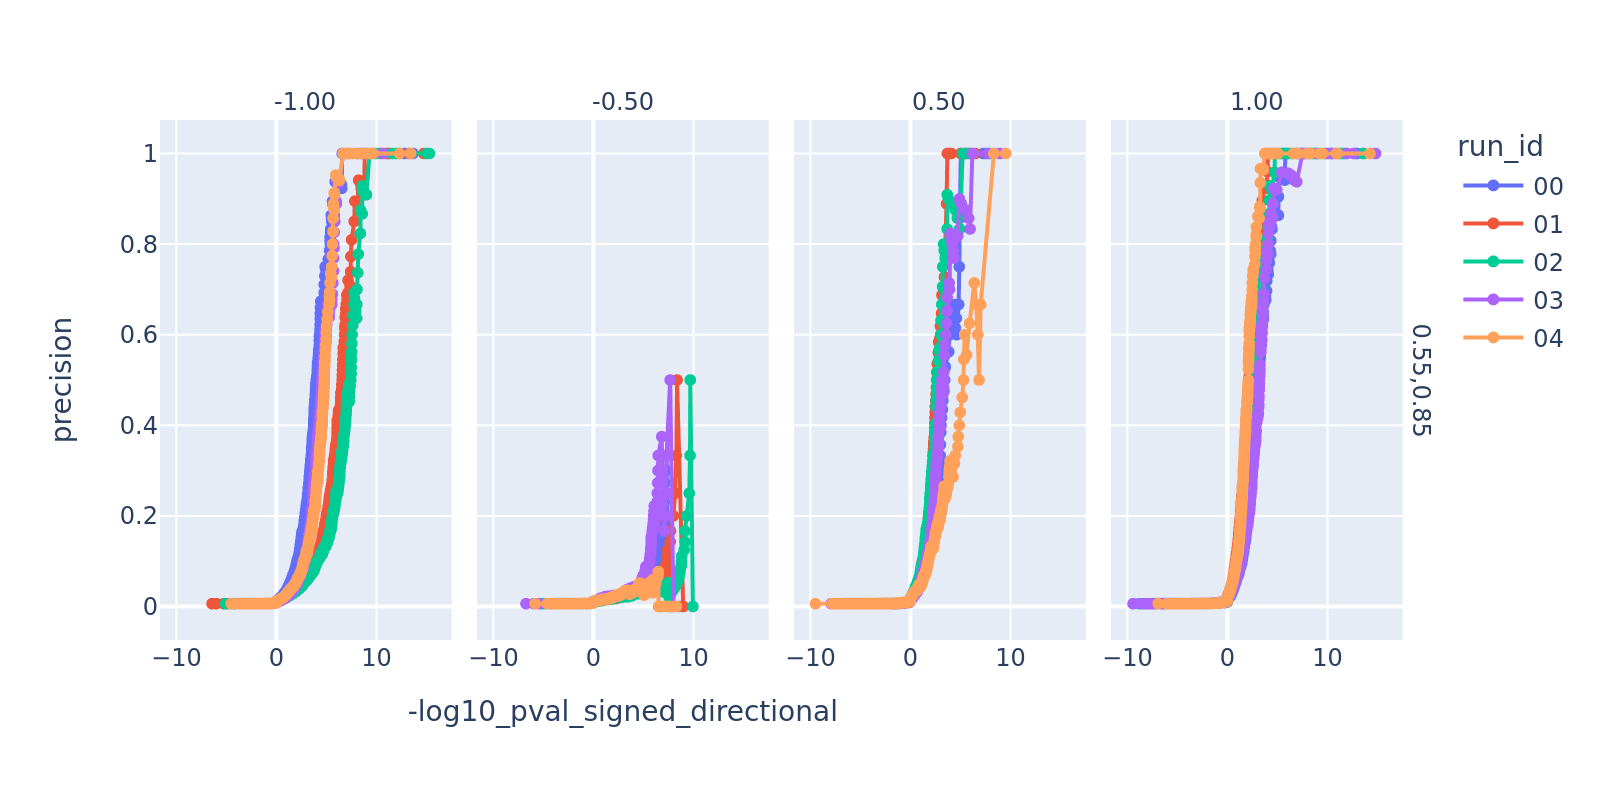

In [33]:
df_to_plot = (
    df_precision_recall_curves
    .xs("0.55,0.85", level="malignant_means", drop_level=False)
    .loc[:, :, "-1.00":"1.00", :]
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)


### Precision & Recall curves

loading extras module


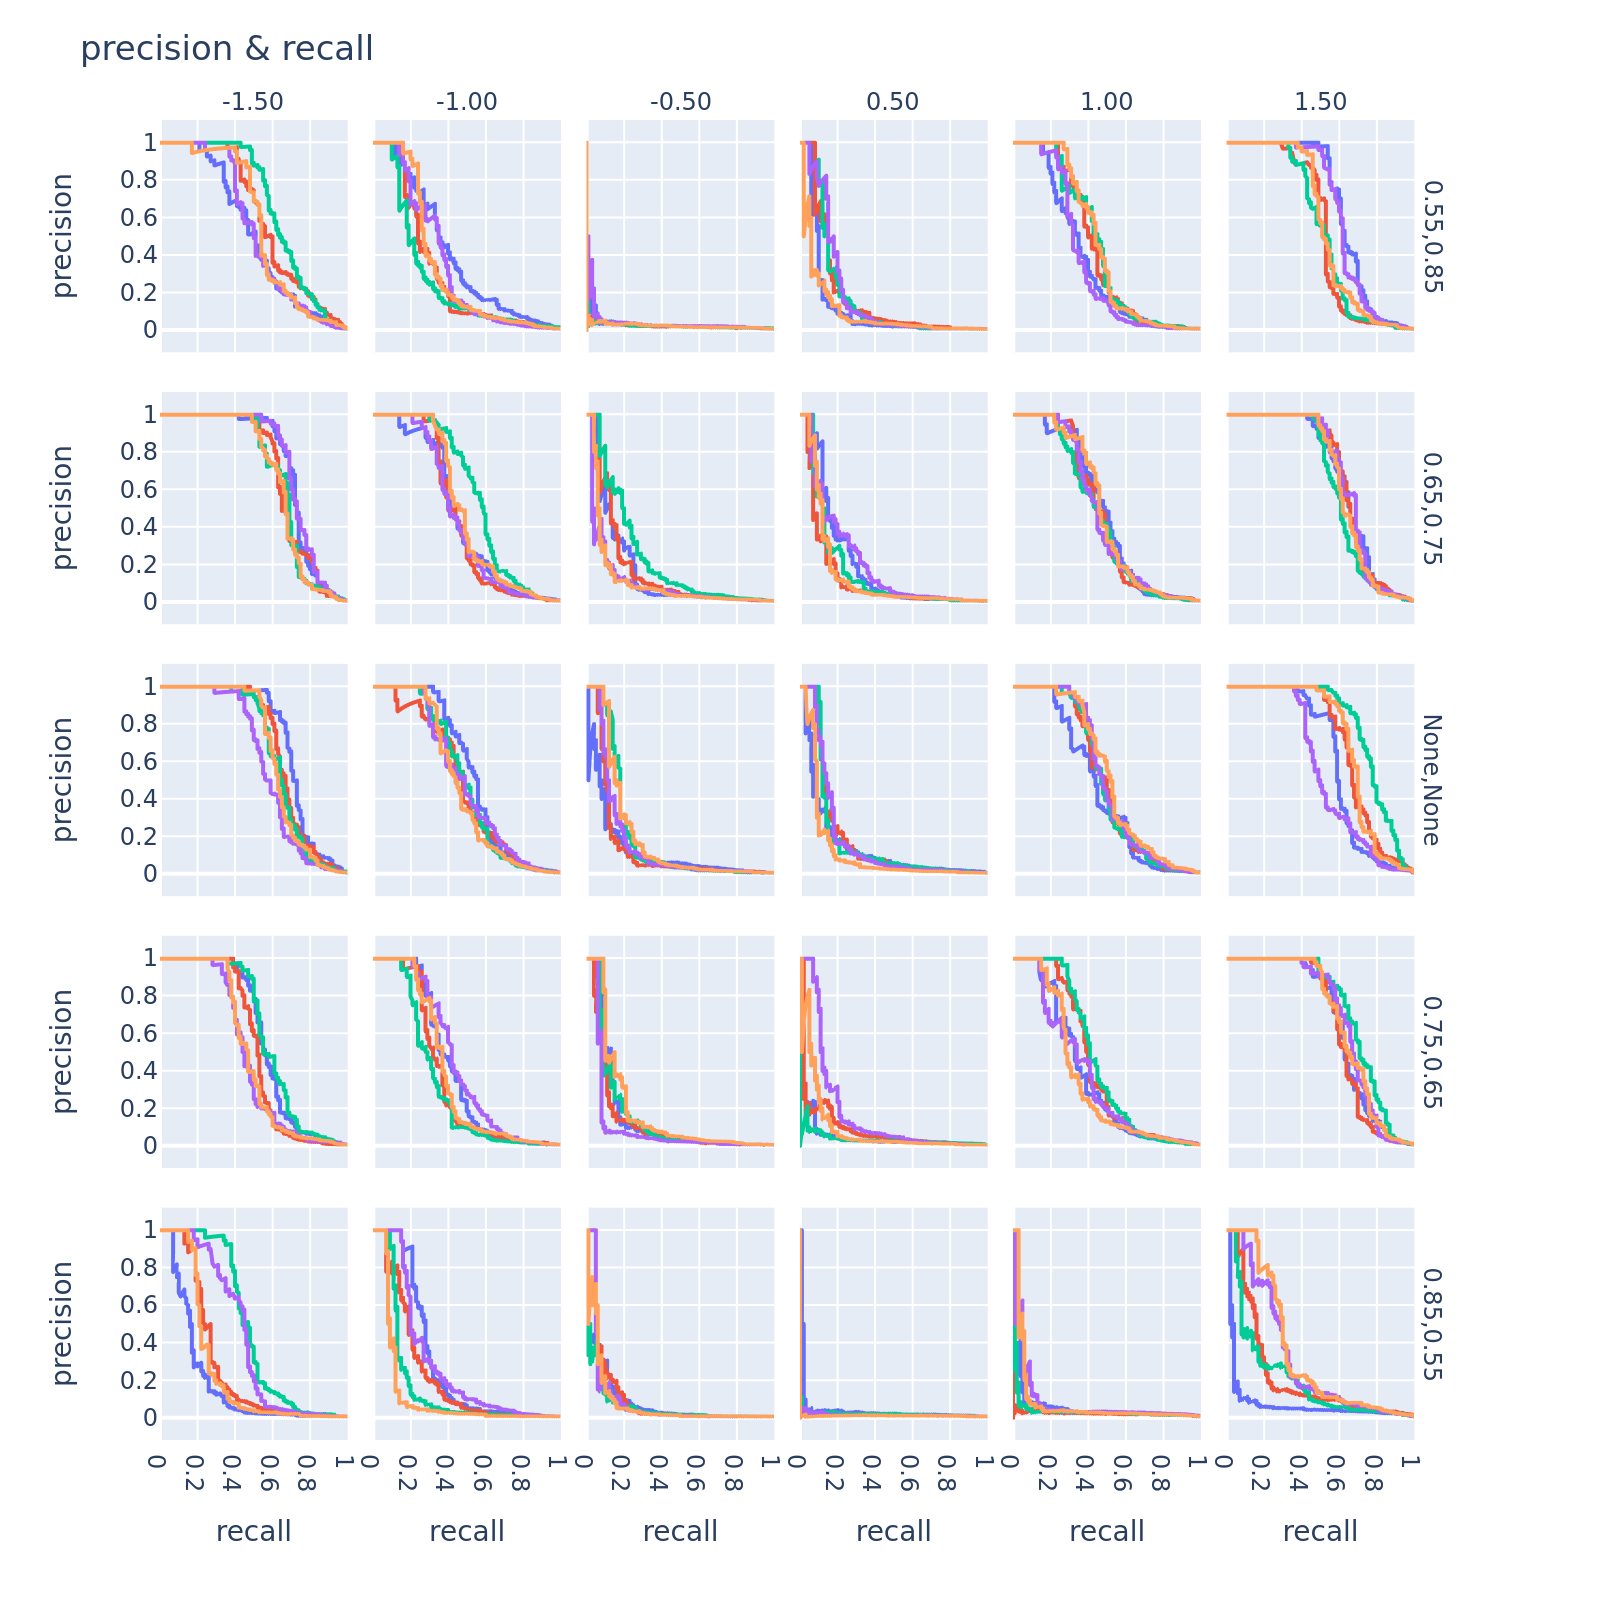

In [39]:
fig = extras.plot_precision_recall_curve(df_precision_recall_curves)
fig.show(renderer="png", scale=2)

### FPR under no perturbation (don't care)

In [ ]:
"""
    # .xs(slice("0.65,0.75", None, 3), level="malignant_means", drop_level=False)
"""
subset = (
    df_gene_stats
    .xs("malignant_cibersortx", level="origin", drop_level=False)
    .xs("0.00", level="log2_fc", drop_level=False)
)
df_to_plot, _ = extras.calculate_roc(
    subset,
    score_column
)
fig = extras.plot_metric_by_threshold(df_to_plot, score_column, "fpr")
fig.show(renderer="png", scale=2)

## checking p-values

In [ ]:
columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    # "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]

# subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00"]
subset_gene_stats = pd.read_parquet(
    # path_root / "gene_stats" / "malignant_cibersortx" / "0.72,0.7" / "1.00" / "gene_stats.parquet"
    path_root / "experiment_id=264/malignant_means=0.72,0.7/log2_fc=1.00/run_id=04/deg_analysis/gene_stats_malignant_cibersortx.parquet"
    )

print(subset_gene_stats.shape)

# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

# plotly line plots of pvals
import plotly.express as px

df_to_plot = subset_gene_stats.sort_values("pval").reset_index()
df_to_plot["perturbed"] = df_to_plot["perturbed"].astype(int)
df_to_plot["size"] = df_to_plot["perturbed"].apply(lambda x: 10 if x == 1 else 5)

fig = px.scatter(
    df_to_plot,
    x="gene_symbol",
    y=columns,
    # use "o" marker if "perturbed" column is True
    color="perturbed",
    size="perturbed",
)
fig